In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import os
import re

import scipy as sc

################################################
# Load in Sample Size Data
################################################

base_path = "./results/"
files = os.listdir(base_path)

file_dfs = []

file_expr = re.compile(r"^Power-.+_stamp(?P<stamp>[a-zA-Z0-9]+)_t(?P<t>\d+)_B(?P<B>\d+)_n(?P<n>\d+)_p(?P<p>\d+)_beta(?P<beta>\d+[.]\d+)_edist(?P<edist>\w+)_seed(?P<seed>\d+)\.csv")
for file in files:
    file_df = pd.read_csv(base_path + file, index_col = 0)
    file_data = re.match(file_expr, file).groupdict()
    file_df["edist"] = file_data["edist"]
    file_df["stamp"] = int(file_data["stamp"])
    file_df["t"] = int(file_data["t"])
    file_df["B"] = int(file_data["B"])
    file_df["n"] = int(file_data["n"])
    file_df["p"] = int(file_data["p"])
    file_df["beta"] = float(file_data["beta"])
    file_dfs.append(file_df)

dispersion_df = pd.concat(file_dfs, ignore_index = True)
del file_dfs


In [3]:
file_path = "Breusch-Pagan_t1000_stamp1732909147.770154_seed112920241000.csv"
bp_df = pd.read_csv(file_path, index_col = 0)
bp_df = bp_df.drop(["alpha", "p"], axis = 1)
bp_df = bp_df.rename({"power" : "BP-Power"}, axis = 1)
bp_df

,n,edist,beta,BP-Power
0,100,Normal,0.0,0.053
1,100,Cauchy,0.0,0.009
2,100,LogNormal,0.0,0.034
3,100,Normal,0.5,0.727
4,100,Cauchy,0.5,0.018
5,100,LogNormal,0.5,0.111
6,100,Normal,1.0,0.994
7,100,Cauchy,1.0,0.030
8,100,LogNormal,1.0,0.243
9,100,Normal,1.5,1.000


In [4]:
all_powers = dispersion_df.groupby(["n", "edist", "beta"])["dispersion-pval"].aggregate(lambda x: np.mean(x <= 0.05)).reset_index()
all_powers = all_powers.rename({ "dispersion-pval" : "PALMRT-Power"}, axis = 1)
all_powers = pd.merge(
    left = all_powers,
    right = bp_df,
    left_on = ["n", "edist", "beta"],
    right_on = ["n", "edist", "beta"],
)

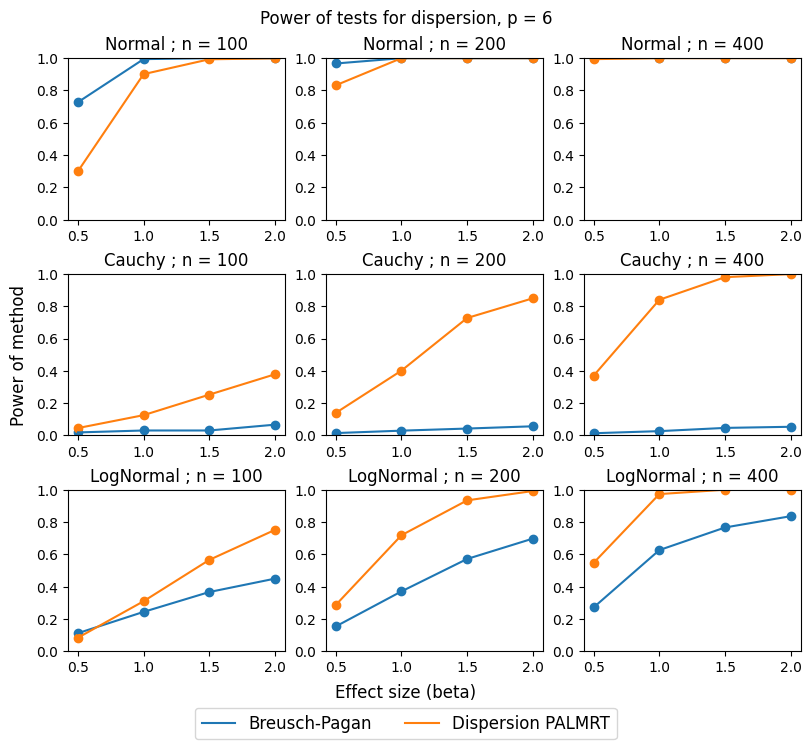

In [27]:
fig = plt.figure(layout="constrained", figsize = (8, 7))
axs = fig.subplots(nrows = 3, ncols = 3)

fig.supxlabel("Effect size (beta)")
fig.supylabel("Power of method")
fig.suptitle(f"Power of tests for dispersion, p = 6")

edists = ["Normal", "Cauchy", "LogNormal"]
ns = [100, 200, 400]

for i, edist in enumerate(edists):
    for j, n in enumerate(ns):
        edist_filter = all_powers["edist"] == edist
        n_filter = all_powers["n"] == n
        beta_filter = all_powers["beta"] > 0
        sub_df = all_powers[edist_filter & n_filter & beta_filter]

        axs[i, j].plot(sub_df["beta"], sub_df["BP-Power"], label = "BP")
        axs[i, j].scatter(sub_df["beta"], sub_df["BP-Power"])

        axs[i, j].plot(sub_df["beta"], sub_df["PALMRT-Power"], label = "PALMRT")
        axs[i, j].scatter(sub_df["beta"], sub_df["PALMRT-Power"])

        axs[i, j].set_ylim((0, 1))

        axs[i, j].set_title(f"{edist} ; n = {n}")

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, ["Breusch-Pagan", "Dispersion PALMRT"], ncols = 2, 
    loc = "lower center", bbox_to_anchor = (0.5, -0.06, 0., 0.), fontsize = 12)

plt.show()
fig.savefig(f"../images/dispersion_sim_power.png", dpi = 300, bbox_inches = "tight")

In [6]:
all_powers[all_powers["beta"] == 0.0]

,n,edist,beta,PALMRT-Power,BP-Power
0,100,Cauchy,0.0,0.007,0.009
5,100,LogNormal,0.0,0.010,0.034
10,100,Normal,0.0,0.004,0.053
15,200,Cauchy,0.0,0.014,0.005
20,200,LogNormal,0.0,0.019,0.029
25,200,Normal,0.0,0.010,0.055
30,400,Cauchy,0.0,0.018,0.008
35,400,LogNormal,0.0,0.022,0.021
40,400,Normal,0.0,0.021,0.055
